In [3]:
import pandas as pd
import gym

from tool_functions import initialize_q_table, evaluate_agent

from Algo_Fonda.qlearning import q_learning
from Algo_Fonda.every_visit_q_mc import every_visit_mc

### Création et étude de l'environnement

Nous allons entraîner notre agent Q-Learning **à naviguer de l'état de départ (S) à l'état cible (G) en marchant uniquement sur les tuiles gelées (F) et en évitant les trous (H)**.

Dans le précédent notebook nous nous sommes intéressés au cas (très) simple d'une carte 4x4. Nous allons maintenant nous intéresser au cas 8x8. (Qui comprend 4 fois plus d'états possibles) 

- `map_name="8x8"` : une version en grille 8x8


Nous restons dans le mode :
- `is_slippery=False` : L'agent se déplace toujours **dans la direction prévue** en raison de la nature non glissante du lac gelé (déterministe).

Récompenses inchangées :  
Si l'agent **atteint l'objectif** il reçoit une **récompense de 1**, s'il ne **l'atteint pas** (se déplace seulement) il reçoit **0** et s'il **tombe dans un trou** il reçoit également **0**.

In [4]:
# 1er cas : carte 4x4 sans glisse 
env = gym.make(
    'FrozenLake-v1',
    map_name="8x8", 
    is_slippery=False
)

state_space = env.observation_space.n
print("Il y a", state_space, "états possibles")

action_space = env.action_space.n
print("Il y a", action_space, "actions possibles")

# Pour l'évaluation des modèles
eval_env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False
)

Il y a 64 états possibles
Il y a 4 actions possibles


In [5]:
# Hyperparamètres partagés par tous les modèles la comparison des modèles

# Entraînement
n_training_episodes = 5000  # Nombre d'épisdoes d'entrainement
max_steps = 1000             # Nombre maximla d'itérations pour un épisode
learning_rate = 0.7         # Taux d'apprentissage (poids accordé au passé pour la mise à jour de la table de Q)
gamma = 0.99

# Exploration 
max_epsilon = 0.8       
min_epsilon = 0.1            
decay_rate = 0.001          # Décroissance exponentielle pour le epsillon considéré par Q de taux decay_rate

# Pour l'affichages des résultats 
res = pd.DataFrame()
smooth = 100 # Lissage des courbes

### Performances d'un estimateur de Monte Carlo Incrémental 

In [6]:
# Obligé de réduire max_steps pour que l'algorithme converge en temps raisonnable 
mc_table = initialize_q_table(state_space, action_space)

mc_table, mc_rewards = every_visit_mc(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=mc_table
)

100%|██████████| 5000/5000 [00:08<00:00, 594.73it/s]


In [7]:
mc_rewards = pd.Series(mc_rewards)
mc_rewards = mc_rewards.rolling(smooth, center=True).mean()
res['IMC-FL'] = mc_rewards

In [8]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=mc_table)

100%|██████████| 100/100 [00:00<00:00, 548.44it/s]


(0.0, 0.0)

### Performances de Q-learning

In [9]:
qlearning_table = initialize_q_table(state_space, action_space)

qlearning_table, rewards = q_learning(
    n_training_episodes=n_training_episodes,
    max_steps=max_steps,
    min_epsilon=0.005,
    max_epsilon=0.9,
    decay_rate=decay_rate,
    learning_rate=learning_rate,
    gamma=gamma,
    env=env,
    Qtable=qlearning_table
)

100%|██████████| 5000/5000 [00:12<00:00, 401.70it/s]


In [10]:
qlearning_rewards = pd.Series(rewards)
qlearning_rewards = qlearning_rewards.rolling(smooth, center=True).mean()
res['qlearning-FL'] = qlearning_rewards

In [11]:
# Lors de l'évaluation plus d'epsillon
evaluate_agent(eval_env, max_steps=100, n_eval_episodes=100, Q=qlearning_table)

100%|██████████| 100/100 [00:00<00:00, 539.59it/s]


(0.0, 0.0)

### Illustrations

In [12]:
import matplotlib.pyplot as plt

<AxesSubplot: title={'center': 'Récompense moyenne par trajectoire'}, xlabel='Trajectoire n°'>

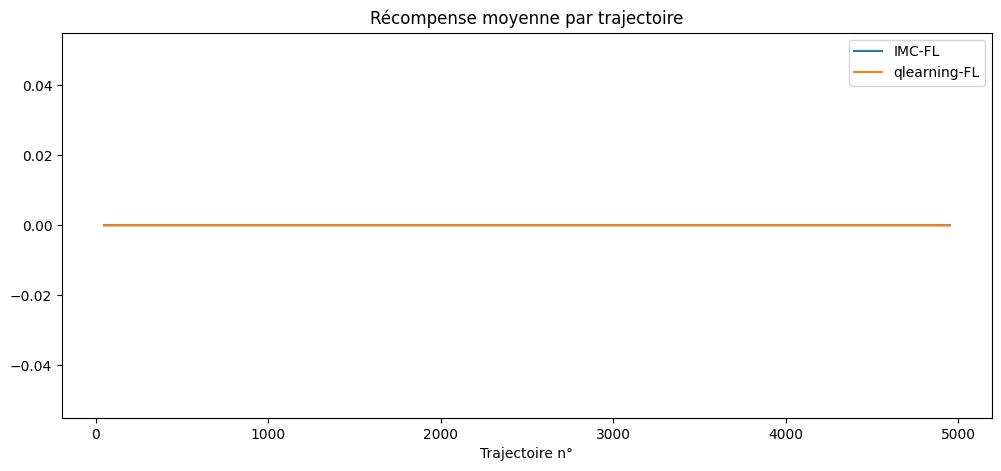

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title("Récompense moyenne par trajectoire")
ax.set_xlabel("Trajectoire n°")
res.plot(ax=ax)

Même en pouvant itérer jusqu'à 1000 pas, les algorithmes ne parviennent pas à converger vers la solution. La carte étant bien plus grande ils ont beaucoup plus d'états à parcourir un grand nombre de fois pour estimer correctement leur valeurs.  

Cela d'autant plus complexe que la distribution des récompenses est particulièrement rude : aucun récompense tant que l'objectif n'est pas atteint. Autrement dit aucune information de "réussite" donné aux algorithmes sauf quand ils atteignent l'état final. Mais comme il faut parcourir bien davatange d'états pour atteindre l'état final..

*Dans la pratique pour n_training_episodes = 50_000 la convergence s'effectue pour les deux algorithmes (effectué sur un colab)* 